In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

from control.matlab import tf, step, lsim
from utils import utils

%matplotlib inline

/home/matthias/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Constants
NA = 4
NB = 5
ALPHA = 10e6



In [3]:
def read_mat(source:str) -> dict:
    """ Read a .mat file and return a dictionary with the data
    
    Args:
        source: path to the .mat file
    
    Returns:
        data: dictionary with the data
    """
    data = scipy.io.loadmat(source)
    data = {k: v.flatten() for k, v in data.items() if not k.startswith("__")}
    return data

data1 = utils.read_mat("/home/matthias/Downloads/ex3/ex3_system1_data.mat")
data2 = utils.read_mat("/home/matthias/Downloads/ex3/ex3_system2_data.mat")

display(data1.keys())
display(data2.keys())

t = data2["t1"]
Ts = t[1] - t[0]


dict_keys(['None', 'README', 't1', 't2', 'u1', 'u2', 'y1', 'y2'])

dict_keys(['README', 't1', 't2', 't3', 'u1', 'u2', 'u3', 'y1', 'y2', 'y3'])

In [4]:
def calc_s_k(y:np.array,u:np.array,n_a,n_b, k) -> list:
    """ Construct the s_k vector
    
    Args:
        y (np.array): Output vector
        u (np.array): Input vector
        n_a (int): Order of the denominator
        n_b (int): Order of the numerator
        k (int): Current index
    
    Returns:
        list: s_k vector
    """
    
    s_a = list(np.zeros(n_a))
    s_b = list(np.zeros(n_b +1))
    
    for i in range(k+1):
        index_a:int = k - i -1

        index_b:int = k - i

        if index_a >= 0:
            try:
                s_a[index_a] = float(y[i])
            except Exception:
                pass
        if index_b >= 0:
            try:
                s_b[index_b] = float(u[i])
            except Exception as e:
                pass
    
    s = s_a + s_b
    return s


In [5]:
def create_plt(p_hat, k:int):
    Gest = tf(p_hat[NA:], [1] + [-p_hat[i] for i in range(NB)], Ts)
    t = data1.get("t1")
    u = data1.get("u1")
    y = data1.get("y1")
    y_test,_ , t_test = lsim(Gest, u, t)
    plt.figure(figsize=(10, 5))
    plt.figure(figsize=(10, 5))
    plt.plot(t,y, label="System Response")
    plt.xlabel("Time [s]")
    plt.plot(t, y_test,label="Model Response")
    plt.legend()
    plt.savefig(f"figures/ex2/IT{k}.png")

def rec_least_squares(n_a:int, n_b:int,k:int, y:np.array, u:np.array, p_hat_k_1:np.array = None, P_k_1:np.array = None) -> tuple[np.array, np.array]:
    """Recursive least squares algorithm.
    p_hat_k_1 and P_k_1 are optional parameters. 
    If they are not provided, they are recursivly calculated.
    
    Args:
        n_a (int): Order of the denominator
        n_b (int): Order of the numerator
        k (int): Current index
        y (np.array): Output vector
        u (np.array): Input vector
        p_hat_k_1 (np.array, Optional): Parameter vector
        P_k_1 (np.array, Optional): Covariance matrix

    
    Returns:
        p_k (np.array): Parameter vector
        P_k (np.array): Covariance matrix
    """        
    if k < 0:
        p_init = np.zeros(NA + NB + 1).reshape(-1,1)
        P_init = np.eye(NA + NB + 1) * ALPHA
        return p_init, P_init
    
    if P_k_1 is None  or p_hat_k_1 is None:
        p_hat_k_1, P_k_1 = rec_least_squares(n_a, n_b, k-1, y, u)
        

    s_k = np.array(calc_s_k(y,u,n_a,n_b,k)).reshape(-1,1)
    k_k = (np.dot(P_k_1, s_k)) / (1 + np.dot(s_k.T, np.dot(P_k_1, s_k)))
    P_K = P_k_1 - np.dot(k_k, np.dot(s_k.T, P_k_1))
    p_hat_k = p_hat_k_1 + k_k * (y[k] - np.dot(s_k.T, p_hat_k_1))

    return p_hat_k, P_K
    

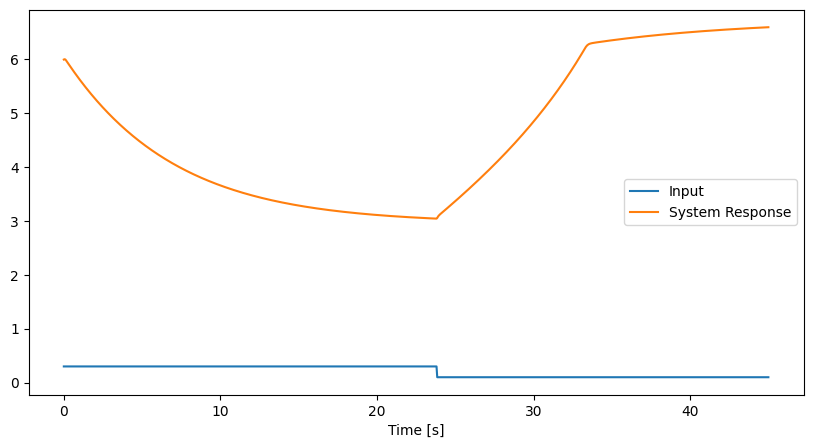

In [10]:
t = data2.get("t1")
u = data2.get("u1")
y = data2.get("y1")
plt.figure(figsize=(10, 5))
plt.plot(t,u, label="Input")
plt.xlabel("Time [s]")
plt.plot(t, y,label="System Response")
plt.legend()
plt.show()


In [7]:

pk_list = []
Pk_list = []
pk, Pk = rec_least_squares(NA, NB, -1, y, u)

for i in range(len(t)):
    pk, Pk = rec_least_squares(NA, NB, i, y, u, pk, Pk)
    pk_list.append(pk)
    Pk_list.append(Pk)
    if i % 20 == 0:
        p_hat = pk.flatten()
        #create_plt(p_hat,i)


    if i > 1:
        dpest = pk_list[-1] - pk_list[-2]
        dnorm = np.linalg.norm(dpest)


p_hat = pk_list[-1].flatten()
print("Estimated Parameters: ", p_hat)
Gest = tf(p_hat[NA:], [1] + [-p_hat[i] for i in range(NB)], Ts)
print(Gest)

Estimated Parameters:  [ 2.25834266e+00 -2.03851079e+00  1.15587851e+00 -4.14702323e-01
 -7.32884151e-07 -4.67971517e-01  5.91972039e-01  2.19960159e-01
 -3.43857438e-01 -1.02664484e-04]
<TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


-7.329e-07 z^5 - 0.468 z^4 + 0.592 z^3 + 0.22 z^2 - 0.3439 z - 0.0001027
------------------------------------------------------------------------
     z^5 - 2.258 z^4 + 2.039 z^3 - 1.156 z^2 + 0.4147 z + 7.329e-07

dt = 0.02



In [8]:
y_test,_ , t_test = lsim(Gest, u, t)

/home/matthias/.local/lib/python3.10/site-packages/control/timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


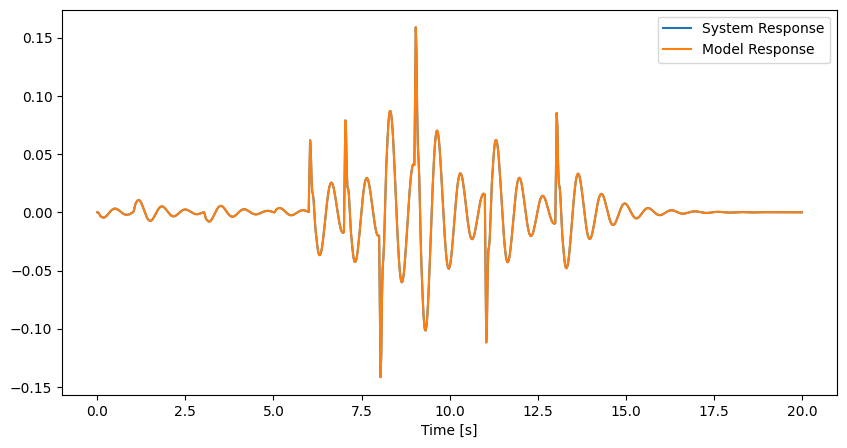

In [9]:

plt.figure(figsize=(10, 5))
plt.plot(t,y, label="System Response")
plt.xlabel("Time [s]")
plt.plot(t, y_test,label="Model Response")
plt.legend()
plt.show()
